In [248]:
#Habilitando o acesso ao Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Neste projeto, iremos analisar o dataset Cardiovascular Disease dataset, extraído do Kaggle: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

###Inicialmente, é realizado um tratamento dos dados, separando, por exemplo, dados categóricos em one-hot vectors. Posteriormente, é feita uma breve análise de correlação entre as features e os labels.

###A seguir, features consideradas menos relevantes são retiradas e features que influenciam indiretamente são combinadas, gerando novas relações. Um exemplo de feature nova criada é o IMC - Índice de massa corporal, que utiliza uma relação entre altura e peso, mostrando-se mais adequado do que apenas essas duas features sozinhas.

###Por fim, utilizando pytorch, é implementada uma MLP para realizar a tarefa de classificação.

Descrição dos dados:

*   Coluna 1: Idade em dias (inteiro)
*   Coluna 2: Altura em cm (inteiro)
*   Coluna 3: Peso em kg (float)
*   Coluna 4: Gênero (dado categórico)
*   Coluna 5: Pressão sanguínea sistólica (inteiro)
*   Coluna 6: Pressão sanguínea diastólica (inteiro)
*   Coluna 7: Colesterol (1 - normal; 2 - acima do normal; 3 muito acima do normal)
*   Coluna 8: Glicose (1 - normal; 2 - acima do normal; 3 muito acima do normal)
*   Coluna 9: Consumo de cigarro (1 - Sim ; 0 - Não)
*   Coluna 10: Consumo de álcool (1 - Sim ; 0 - Não)
*   Coluna 11: Realiza atividade física (1 - Sim ; 0 - Não)
*   Coluna 12: Presença ou ausência de doença cardiovascular (1 - Sim ; 0 - Não)

In [249]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

#Importando o dataset
dataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/cardio_train.csv", sep=';')
dataset

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [250]:
#A primeira coluna é indiferente para análise. Por isso, iremos eliminá-la
dataset = dataset.drop(columns=["id"])

In [251]:
#Vamos checar o balanceamento dos True Negativos(Não tem doença cardíaca) e True Positivos(tem doença cardíaca do dataset)
positivo = 0
negativo = 0
for i in dataset['cardio']:
  if(dataset['cardio'][i] == 1):
    positivo += 1
  elif(dataset['cardio'][i] == 0):
    negativo += 1
  else:
    print("ERRO NO LABEL DO DATASET")

print("POSITIVO: ", positivo)
print("NEGATIVO: ", negativo)

#Como os dados estão balanceados, não é necessário realizar um balenceamento

POSITIVO:  34979
NEGATIVO:  35021


Para uma análise extra e treinar a manipulação dos dados, vamos medir o índice de massa corporal de cada um dos indivíduos. Não se trata de uma medida ideal pois provavelmente um indicador da porcentagem de gordura corporal traria melhores resultados, porém é uma análise válida que pode ser feita. O cálculo do IMC é dado por:

$$\frac{Peso}{Altura^2}$$

Onde a altura é calculada em metros e o peso em kg.


In [252]:
peso = dataset['weight']
altura = dataset['height']/100

IMC = peso/(altura*altura)

dataset['imc'] = IMC
dataset

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,imc
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,19240,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69996,22601,1,158,126.0,140,90,2,2,0,0,1,1,50.472681
69997,19066,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,22431,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


In [253]:
#Agora, iremos analisar a correlação entre as features e o label.
#Começando com dados quantitativos, iremos criar um heatmap para analisar a correlação entre uma feature e a presença de doença cardiovascular.
categorical_data = dataset[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']]
numerical_data = dataset[['age', 'height', 'weight', 'ap_hi', 'ap_lo','imc', 'cardio']]

Agora vamos normalizar os dados numéricos. Para isso, utilizaremos o min-max feature scaling, que reescala os dados para o range [0,1] através da equação:
    $$ \frac{X_{norm}}{X_{max} -X_{min}} $$

In [254]:
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

numerical_data = min_max_scaling(numerical_data)
numerical_data

,age,height,weight,ap_hi,ap_lo,imc,cardio
0,0.588076,0.579487,0.273684,0.016079,0.013550,0.062655,0.0
1,0.730159,0.517949,0.394737,0.017934,0.014453,0.106560,1.0
2,0.624003,0.564103,0.284211,0.017316,0.012647,0.067874,1.0
3,0.528455,0.584615,0.378947,0.018553,0.015357,0.085498,1.0
4,0.516918,0.517949,0.242105,0.015461,0.011743,0.066192,0.0
...,...,...,...,...,...,...,...
69995,0.653659,0.579487,0.347368,0.016698,0.013550,0.079458,0.0
69996,0.913899,0.528205,0.610526,0.017934,0.014453,0.159220,1.0
69997,0.640186,0.656410,0.500000,0.020408,0.014453,0.094452,1.0
69998,0.900736,0.553846,0.326316,0.017625,0.013550,0.080040,1.0


In [255]:
#Transformando dados categóricos em one-hot vectors
categorical_data = pd.concat([categorical_data, pd.get_dummies(categorical_data['gender'], prefix='gender')], axis = 1)
categorical_data = pd.concat([categorical_data, pd.get_dummies(categorical_data['cholesterol'], prefix='cholesterol')], axis = 1)
categorical_data = pd.concat([categorical_data, pd.get_dummies(categorical_data['gluc'], prefix='gluc')], axis = 1)
categorical_data = pd.concat([categorical_data, pd.get_dummies(categorical_data['cardio'], prefix='cardio')], axis = 1)

#Retirando os que não são one-hot 
categorical_data = categorical_data.drop(columns=['gender', 'cholesterol', 'gluc'])

categorical_data


,smoke,alco,active,cardio,gender_1,gender_2,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,cardio_0,cardio_1
0,0,0,1,0,0,1,1,0,0,1,0,0,1,0
1,0,0,1,1,1,0,0,0,1,1,0,0,0,1
2,0,0,0,1,1,0,0,0,1,1,0,0,0,1
3,0,0,1,1,0,1,1,0,0,1,0,0,0,1
4,0,0,0,0,1,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,1,0,1,0,0,1,1,0,0,1,0,0,1,0
69996,0,0,1,1,1,0,0,1,0,0,1,0,0,1
69997,0,1,0,1,0,1,0,0,1,1,0,0,0,1
69998,0,0,0,1,1,0,1,0,0,0,1,0,0,1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f73afa0b0b8>],
      dtype=object)

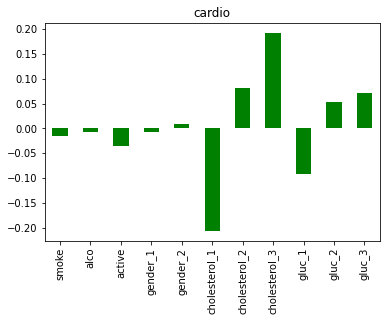

In [256]:
#Vamos criar um BarPlot para analisar a correlação das features com o label
#Para a correlação, utilizaremos o método de pearson
aux_cat_data = categorical_data.drop(columns=['cardio_0', 'cardio_1'])
cor_pearson = aux_cat_data.corr(method='pearson')

#Dropando o cardio, pois ele tem uma relação de 1 para 1 com o cárdio
cor_pearson = cor_pearson.drop('cardio')

#Plotando um gráfico de barras com a correlação
cor_pearson['cardio'].plot.bar(subplots=True, color='g')


Como podemos notar pelo gráfico, algumas features possuem uma relação muito baixa com doenças cardíacas, como por exemplo fumar, alcool, genero

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f73ae857780>],
      dtype=object)

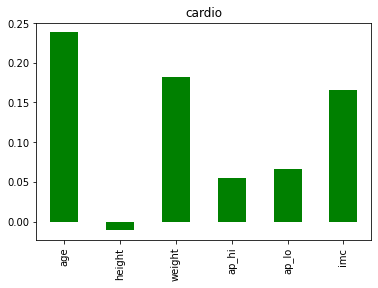

In [257]:
#Agora, vamos analisar os dados numéricos
#Para a correlação, utilizaremos o método de pearson
cor_pearson = numerical_data.corr(method='pearson')

#Dropando o cardio, pois ele tem uma relação de 1 para 1 com o cárdio
cor_pearson = cor_pearson.drop('cardio')

#Plotando um gráfico de barras com a correlação
cor_pearson['cardio'].plot.bar(subplots=True, color='g', )

Removeremos da análise a altura, pois diretamente ela não tem alta correlação com o fato da pessoa ter doença cardíaca ou não.

Além disso, note que o imc possui uma correlação menor do que o peso. Isso se dá pois, analisando apenas o peso, acabamos levando em consideração indivíduos que são mais pesados por terem um maior indice de massa corporal e também indivíduos que são mais pesados por serem mais altos. Dessa forma, utilizando o IMC, excluímos o segundo caso.


###Agora vamos separar os dados de treino e teste, tão bem como as features e labels. Além disso, retiraremos as features que não serão utilizadas no treino.

###Faremos duas análises. Uma considerando apenas o IMC e não o peso, e outra considerando apenas o peso e não o IMC.


In [258]:
#Dados para o treino considerando o Peso
aux1 = numerical_data[["age", "weight", "ap_hi", "ap_lo"]]
aux2 = categorical_data[["cholesterol_1", "cholesterol_2", "cholesterol_3", "gluc_1", "gluc_2", "gluc_3", "cardio_0", "cardio_1"]]
aux3 = pd.concat([aux1, aux2], axis=1)

train_weight_x, train_weight_y = aux3.iloc[0:60000, 0:10], aux3.iloc[0:60000, 10:12]

test_weight_x, test_weight_y = aux3.iloc[60001: -1, 0:10], aux3.iloc[60001: -1, 10:12]

#Dados para o treino considerando o IMC
aux1 = numerical_data[["age", "imc", "ap_hi", "ap_lo"]]
aux2 = categorical_data[["cholesterol_1", "cholesterol_2", "cholesterol_3", "gluc_1", "gluc_2", "gluc_3", "cardio"]]
aux3 = pd.concat([aux1, aux2], axis=1)

train_imc_x, train_imc_y = aux1.iloc[0:60000, 0:10], aux3.iloc[0:60000, 10:11]

test_imc_x, test_imc_y = aux3.iloc[60001:70000, 0:10], aux3.iloc[60001:70000, 10:11]

## **Agora vamos para o treino :)** 



Primeiramente, vamos criar nosso modelo de análise. Para este problema, foi escolhida uma Multi-Layer Perceptron para realizar a classificação.

A arquitetura usada pela rede foi:

Learning Rate: 

Abaixo, é definido o modelo da nossa rede

In [259]:
#Definindo o modelo da rede
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class Cardio_Model(nn.Module):
  def __init__(self):
    super(Cardio_Model, self).__init__()

    self.fc1 = nn.Linear(10, 8)

    self.fc2 = nn.Linear(8, 6)
    self.fc3 = nn.Linear(6, 2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    return F.sigmoid(self.fc3(x))

#Testando a rede
model = Cardio_Model()
model

Cardio_Model(
  (fc1): Linear(in_features=10, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=2, bias=True)
)

##**Definindo Variáveis e Hiperparâmetros**


In [260]:
#Definindo Variáveis e Hiperparâmetros
BATCH_SIZE = 1024
EPOCHS = 250
LEARNING_RATE = 0.002
print_results = 60000

#Criando o modelo
cardio_model = Cardio_Model()

#Setando o optimizador e a loss function
optimizer = torch.optim.Adam(params=cardio_model.parameters(), lr=LEARNING_RATE)
loss_function = nn.BCELoss()

Agora, vamos separar nossos dados em batches




In [261]:
tensor_x = torch.tensor(train_weight_x.values, dtype=torch.float32)
tensor_y = torch.tensor(train_weight_y.values, dtype=torch.float32)

In [262]:
dl_train_weight_x = torch.utils.data.DataLoader(tensor_x, batch_size=BATCH_SIZE)
dl_train_weight_y = torch.utils.data.DataLoader(tensor_y, batch_size=BATCH_SIZE)

Agora, vamos treinar a rede

In [263]:
#Guarda a loss ao longo das épocas para posteriormente plotar seu gráfico
loss_over_epochs = []

#Treinando o modelo
for epoch in range(EPOCHS):
  #Carregando os iteradores de batch
  iter_x = iter(dl_train_weight_x)
  iter_y = iter(dl_train_weight_y)

  for i in range(0, len(train_weight_x), BATCH_SIZE):

    #Alocando batch do iterador
    batch_X = iter_x.next()
    batch_y = iter_y.next()

    #Zerando a loss function para não acumular
    cardio_model.zero_grad()

    #Forward Prop
    outputs = cardio_model(batch_X)

    #Calculando a loss
    loss = loss_function(outputs, batch_y)
    #Backward Prop
    loss.backward()

    #Atualizando os pesos
    optimizer.step()

    if i % print_results == 0:
      #Printando perda e informações
      loss_over_epochs.append(loss.item())
      print("Train Epoch: ", epoch, "   LOSS: ", loss.item())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch:  0    LOSS:  0.7040456533432007
Train Epoch:  1    LOSS:  0.6891351938247681
Train Epoch:  2    LOSS:  0.6607435941696167
Train Epoch:  3    LOSS:  0.6476795673370361
Train Epoch:  4    LOSS:  0.6382497549057007
Train Epoch:  5    LOSS:  0.6297762393951416
Train Epoch:  6    LOSS:  0.6236057877540588
Train Epoch:  7    LOSS:  0.6200417876243591
Train Epoch:  8    LOSS:  0.6181237101554871
Train Epoch:  9    LOSS:  0.6170479655265808
Train Epoch:  10    LOSS:  0.616327166557312
Train Epoch:  11    LOSS:  0.6158224940299988
Train Epoch:  12    LOSS:  0.6154344081878662
Train Epoch:  13    LOSS:  0.6151894927024841
Train Epoch:  14    LOSS:  0.6149450540542603
Train Epoch:  15    LOSS:  0.6147929430007935
Train Epoch:  16    LOSS:  0.6145835518836975
Train Epoch:  17    LOSS:  0.6143770217895508
Train Epoch:  18    LOSS:  0.6141066551208496
Train Epoch:  19    LOSS:  0.613876223564148
Train Epoch:  20    LOSS:  0.6136170625686646
Train Epoch:  21    LOSS:  0.6134771108627319


##**Abaixo, temos o gŕafico da Loss ao longo do treinamento.**

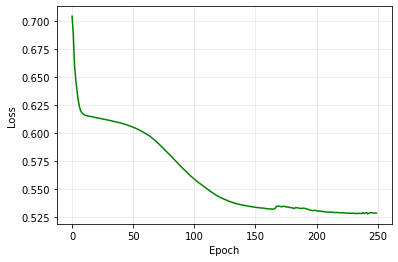

In [264]:
#Plotando a Loss
import matplotlib.pyplot as plt

plt.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
plt.plot(loss_over_epochs, color='g', linewidth=1.5)

plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.show()

##**Por fim, vamos avaliar a acurácia do nosso modelo**

In [265]:
tensor_test_x = torch.tensor(test_weight_x.values, dtype=torch.float32)
tensor_test_y = torch.tensor(test_weight_y.values, dtype=torch.float32)

In [266]:
dl_test_weight_x = torch.utils.data.DataLoader(tensor_test_x, batch_size=1)
dl_test_weight_y = torch.utils.data.DataLoader(tensor_test_y, batch_size=1)

In [267]:
correct = 0
total = 0
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

#Carregando os iteradores de batch
iter_x = iter(dl_test_weight_x)
iter_y = iter(dl_test_weight_y)

with torch.no_grad():
  for i in tqdm(range(len(test_weight_x))):

    #Alocando batch do iterador
    batch_X = iter_x.next()
    batch_y = iter_y.next()

    real_class = torch.argmax(batch_y)
    net_out = cardio_model(batch_X)
    
    predicted_class = torch.argmax(net_out)

    #print("NET OUT: ", net_out)
    #print("REAL CLASS: ", real_class)

    if(predicted_class == real_class):
      correct += 1
      #True Positive
      if(predicted_class.item() == 1):
        true_positive += 1
      #True Negative
      if(predicted_class.item() == 0):
        true_negative += 1

    else:
      #False Positive 
      if(predicted_class.item() == 1):
        false_positive += 1
      #False Negative
      elif(predicted_class.item() == 0):
        false_negative += 1

      
    total += 1

  0%|          | 0/9998 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 9998/9998 [00:01<00:00, 6910.67it/s]


Accuracy:  0.7224444888977796



Text(33.0, 0.5, 'Positive/Negative')

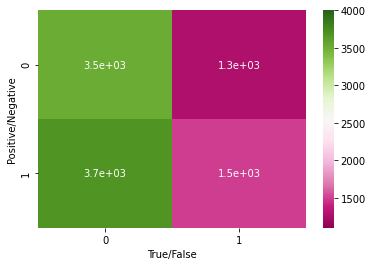

In [268]:
#Printando a acurácia e a confusion matrix
from sklearn.metrics import plot_confusion_matrix

print("Accuracy: ", correct/total)
print("") 

confusion_matrix = [[true_positive, false_positive], [true_negative, false_negative]]

sb.heatmap(confusion_matrix, vmin=1100, vmax=4000, annot=True, cmap="PiYG")
plt.xlabel("True/False")
plt.ylabel("Positive/Negative")

##Com isso, é possível ver que obtemos uma acurácia de aproximadamente 72% no nosso classificador. Analisando as discussões sobre esse dataset no kaggle, ninguém conseguiu ainda uma acurácia maior que essa.

##Além disso, a autora do dataset ainda não forneceu a fonte deles, ou seja, não sabemos de onde os dados foram retirados.

##Desse modo, essa baixa acurácia pode se dar por vários fatores. Existe a possibilidade de ninguém ter achado uma combinação de features, uma arquitetura ou modelo que maximizem os resultados. Como também é possível que os dados estejam viesados. 

##De qualquer forma, foi um ótimo exercício para praticar!